In [26]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

from sklearn.ensemble import RandomForestRegressor

from warnings import filterwarnings
filterwarnings('ignore')

### Drops features which have correlation (between two features) greater than or equal given threshold considering their correlation to total_cases

In [27]:
# remove correlated columns
def drop_correlation(dataset, labels, threshold):
    corr_total_cases = pd.concat([dataset, labels], axis=1).corr().total_cases.drop('total_cases')
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if np.absolute(corr_matrix.iloc[i, j]) >= threshold:
                colname_i = corr_matrix.columns[i] # getting the name of column
                colname_j = corr_matrix.columns[j]
                if corr_total_cases[colname_i] < corr_total_cases[colname_j]:
                    if colname_i in dataset.columns:
                        del dataset[colname_i]
                        col_corr.add(colname_i)
                else:
                    if colname_j in dataset.columns:
                        del dataset[colname_j]
                        col_corr.add(colname_j)

### Plots HeatMap of a given dataset

In [28]:
# plot heat map of dataset
def plotHeatMap(dataset):
    f,ax = plt.subplots(figsize=(18, 18))
    sn.heatmap(dataset.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Reading all dataset - train and test, Concating total_cases

In [29]:
filepath = 'dataset'
X = pd.read_csv(filepath + '/dengue_features_train.csv')
Y = pd.read_csv(filepath + '/dengue_labels_train.csv')
T = pd.read_csv(filepath + '/dengue_features_test.csv')

# concating total cases to train data frame - beacuse of issue in removing outliers
X = pd.concat([Y['total_cases'], X], axis=1)

X.shape

(1456, 25)

### Drops columns having more than 10% NaN values

In [30]:
NaNDic = (X.isnull().sum()*100/X.shape[0])>=10
for i in X.columns.values:
    if(NaNDic[i]):
        X.drop(i,axis=1,inplace=True)
        T.drop(i,axis=1,inplace=True)

### Seperating into two cities, Filling null values - interpolation

In [31]:
# seperate into two cities
X_sj = X[X['city'] == "sj"]
X_iq = X[X['city'] == "iq"]
T_sj = T[T['city'] == "sj"]
T_iq = T[T['city'] == "iq"]
# drop columns
dropping_columns = ['city']
X_sj = X_sj.drop(dropping_columns, axis=1)
X_iq = X_iq.drop(dropping_columns, axis=1)
T_sj = T_sj.drop(dropping_columns, axis=1)
T_iq = T_iq.drop(dropping_columns, axis=1)
# fill NaN values
X_sj.interpolate(inplace=True)
X_iq.interpolate(inplace=True)
T_sj.interpolate(inplace=True)
T_iq.interpolate(inplace=True)

### Removing outliers

In [32]:
X_sj = X_sj[(np.abs(stats.zscore(X_sj.drop(['year','weekofyear','week_start_date','total_cases'],axis=1))) < 5).all(axis=1)]
X_iq = X_iq[(np.abs(stats.zscore(X_iq.drop(['year','weekofyear','week_start_date','total_cases'],axis=1))) < 5).all(axis=1)]

In [33]:
# sperating total_cases label again
L_sj = pd.DataFrame(X_sj['total_cases'])
L_iq = pd.DataFrame(X_iq['total_cases'])

# drop total_cases and back X_sj,X_iq in dataset
X_sj = X_sj.drop(['total_cases'],axis=1)
X_iq = X_iq.drop(['total_cases'],axis=1)

X_sj.drop(['year','week_start_date'], axis=1, inplace=True)
X_iq.drop(['year','week_start_date'], axis=1, inplace=True)

### Correlation Analysis

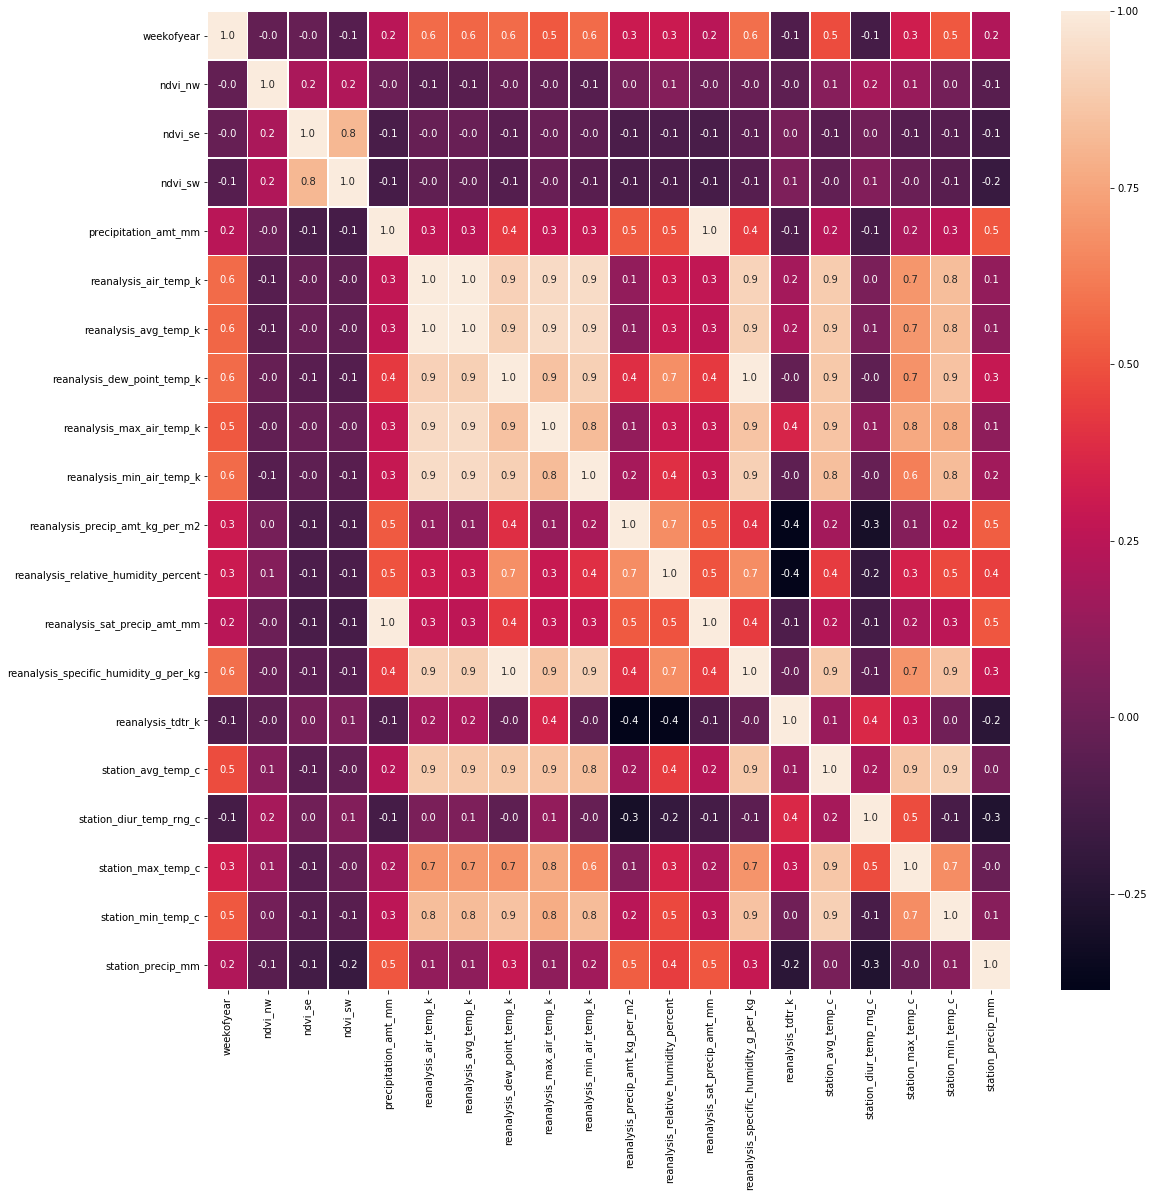

In [34]:
plotHeatMap(X_sj)

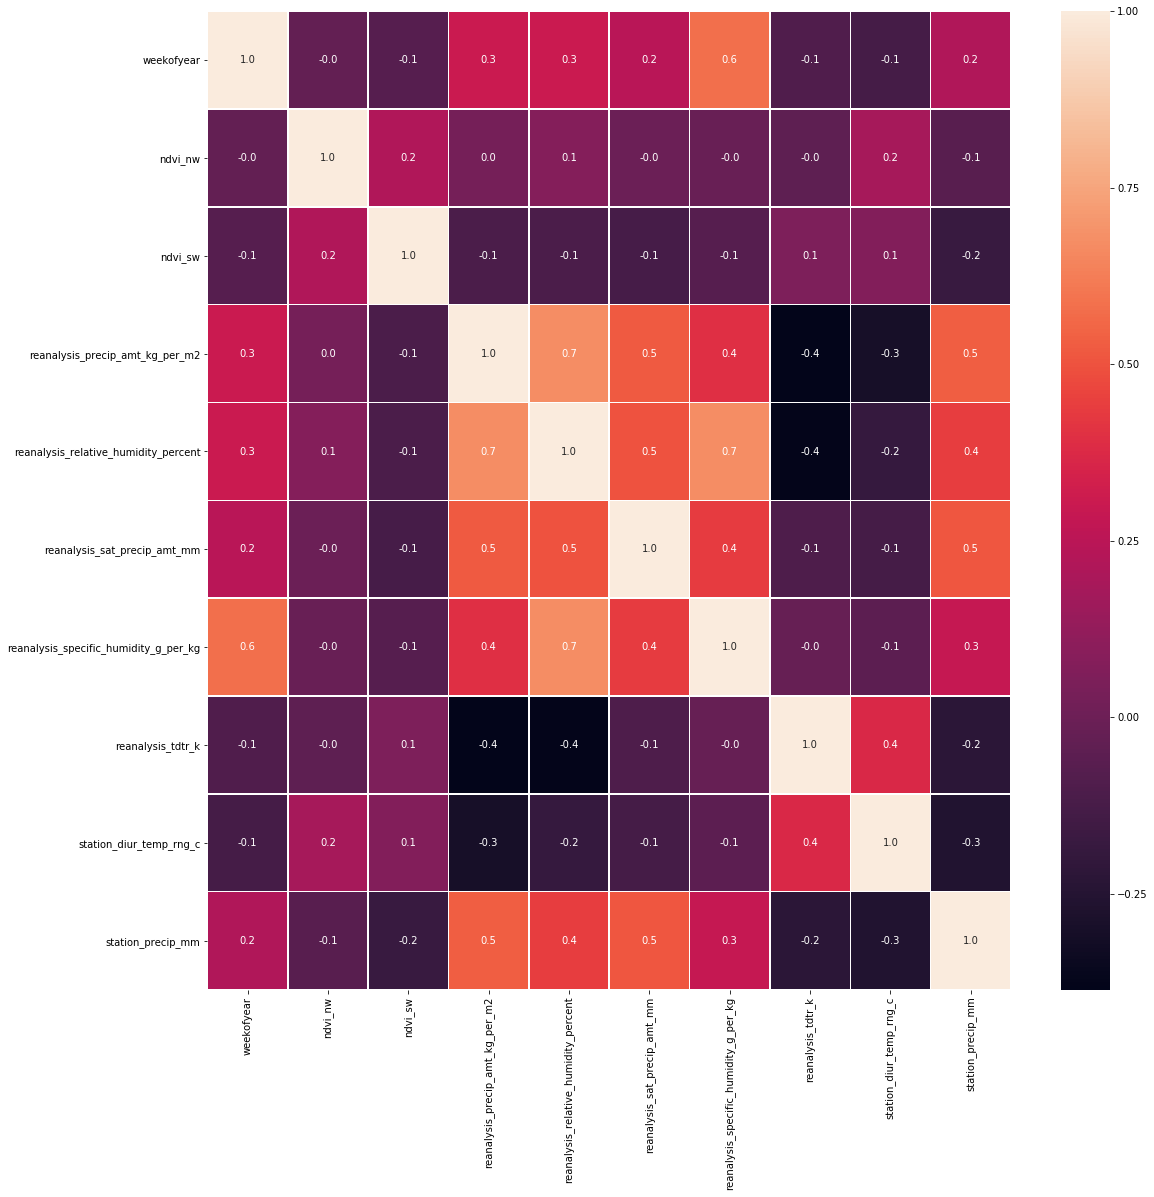

In [35]:
drop_correlation(X_sj,L_sj,0.8)
plotHeatMap(X_sj)

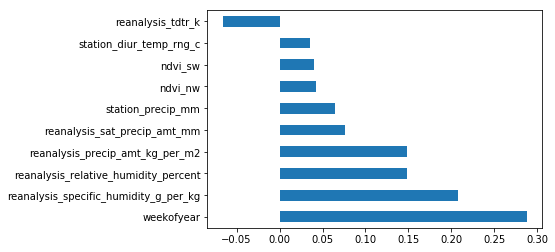

In [36]:
sj_correlations = pd.concat([X_sj, L_sj], axis=1).corr().total_cases.drop('total_cases')
sj_correlations.sort_values(ascending=False).plot.barh()

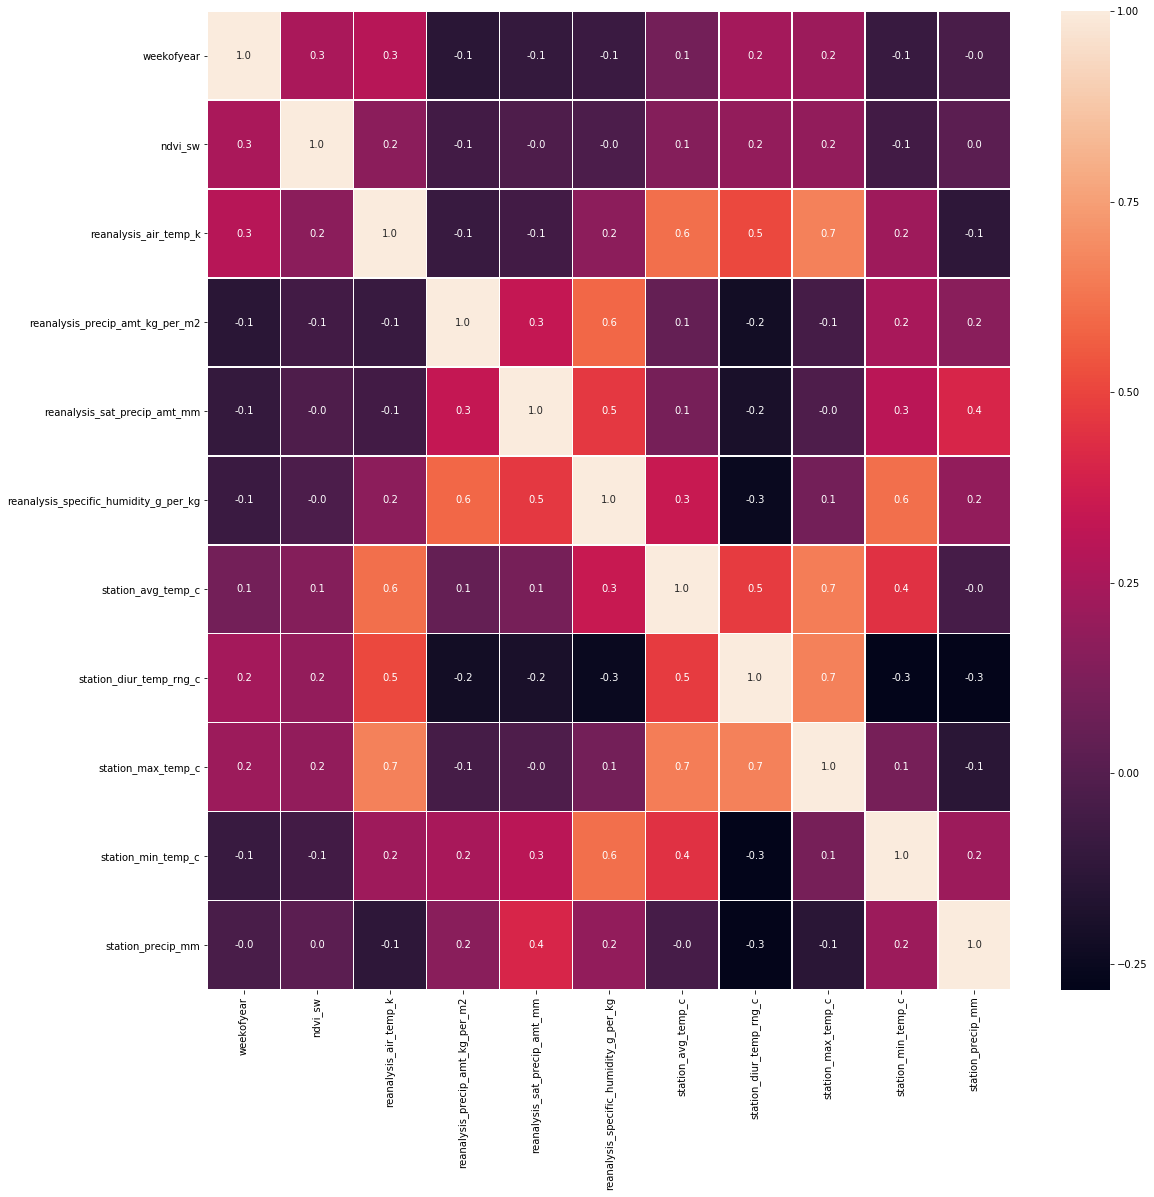

In [37]:
# plotHeatMap(X_iq)
drop_correlation(X_iq,L_iq,0.7)
plotHeatMap(X_iq)

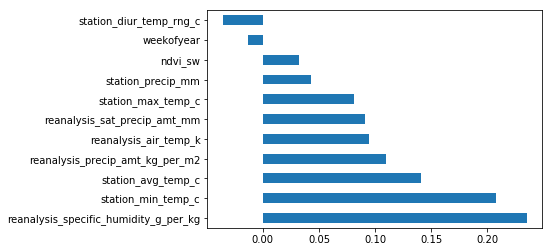

In [38]:
iq_correlations = pd.concat([X_iq, L_iq], axis=1).corr().total_cases.drop('total_cases')
iq_correlations.sort_values(ascending=False).plot.barh()

### Feature selection and smoothing

In [39]:
X_sj_train = X_sj[['weekofyear', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm']]
X_iq_train = X_iq[['reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c', 'station_avg_temp_c', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_air_temp_k']]

X_sj_train_roll = pd.rolling_mean(X_sj_train,12)
X_sj_train = pd.concat([X_sj_train[:11],X_sj_train_roll[11:]],axis=0)

X_iq_train_roll = pd.rolling_mean(X_iq_train,12)
X_iq_train = pd.concat([X_iq_train[:11],X_iq_train_roll[11:]],axis=0)

### Training two models - model per city

In [40]:
forest_model_sj = RandomForestRegressor(n_estimators=10000)
forest_model_sj.fit(X_sj_train, L_sj)

forest_model_iq = RandomForestRegressor(n_estimators=10000)
forest_model_iq.fit(X_iq_train, L_iq)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Predicting

In [41]:
T_sj_predict = T_sj[['weekofyear', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm']]
T_iq_predict = T_iq[['reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c', 'station_avg_temp_c', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_air_temp_k']]

In [42]:
forest_predict_sj = forest_model_sj.predict(T_sj_predict)
forest_predict_iq = forest_model_iq.predict(T_iq_predict)

In [43]:
predict_list = list((forest_predict_sj).astype(int)) + list((forest_predict_iq).astype(int))

In [45]:
S = pd.read_csv(filepath + '/submission_format.csv')

S['total_cases'] = predict_list

S

S.to_csv('results/forest_noNormalize.csv', index=False)